# Fake News Identification: Machine Learning and Deep Learning Approaches.

In this project, I aim to differentiate between dirty and clean plates using machine learning. The dataset, sourced from a Kaggle competition. 
<br>I will utilize transfer learning to leverage pre-trained models, enhancing classification accuracy. 
<br>After training, I will implement an active learning approach, where I will select samples with the highest likelihood predictions from 
<br>an unlabeled dataset. These selected samples will then be labeled and added to the training set, allowing me to iteratively improve the model. 
<br>Ultimately, I will submit the predictions on the Kaggle platform and apply the trained model to my own images of plates to assess 
<br>its performance in real photos by uploading here.

<br> Data set is provided form [`Kaggle Breast Ultrasound Images Dataset(BUSI)`](https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset)

## Outline
- [ 1 - Result model examples](#1)
- [ 1 - Import Data](#2)
- [ 2 - ML models](#2)
  - [ 2.1 - SVM](#2.1)
  - [ 2.2 - Naive Bayes](#2.2)
  - [ 2.3 - Logistic Regression](#2.3)
- [ 3 - Neuron networks](#3)
  - [ 3.1 - Convolutional NN](#3.1)
  - [ 3.2 - LSTM](#3.2)
  - [ 3.3 - Bidirectional LSTM](#3.3)
- [ 4 - Fine-Tuning (DistilBert)](#4)

<a name="1"></a>
## 1 - Result model examples

Random 4 images of each class with prediction

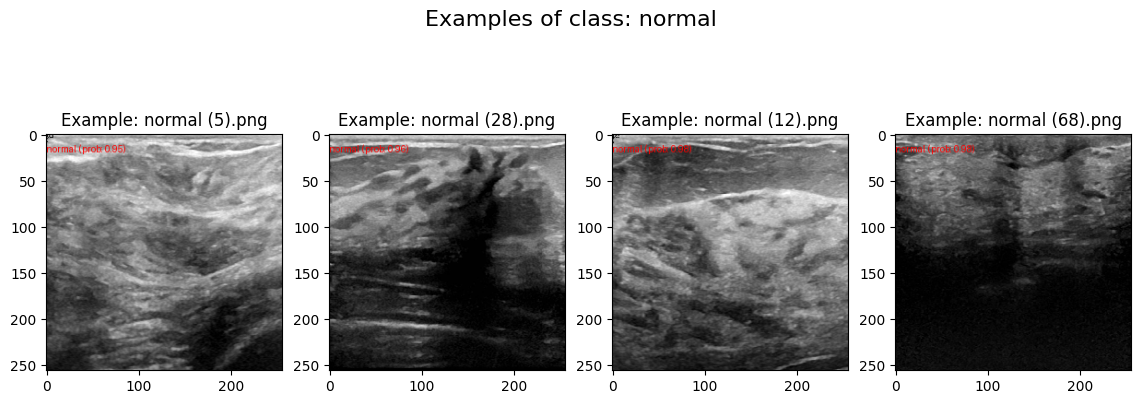

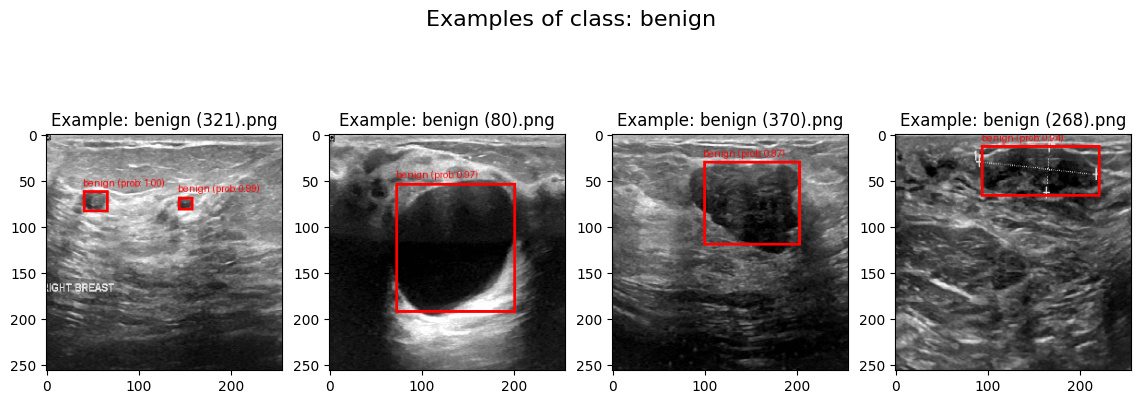

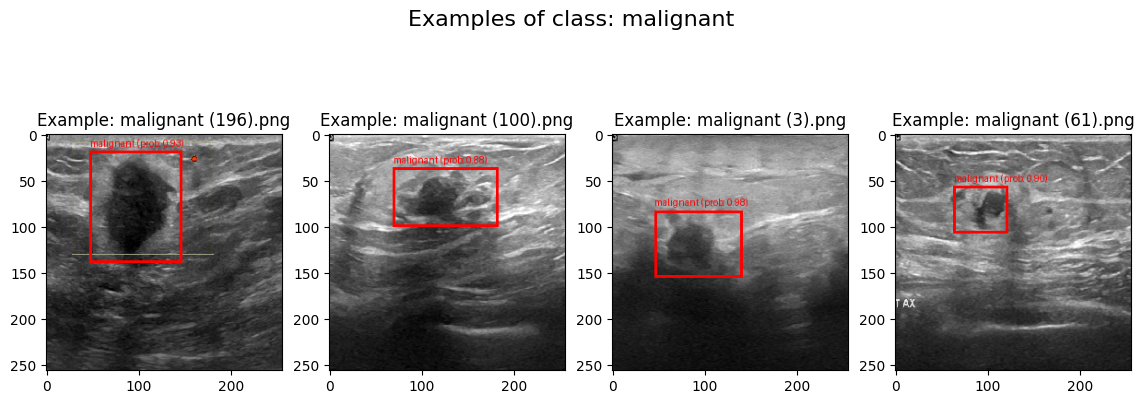

In [550]:
for i in ["normal", "benign", "malignant"]:
    show_model_result_examples("/Users/sergeiakhmadulin/My Drive/Breast Cancer",i)

<a name="1"></a>
## 1 - Import Data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img

from IPython.display import display
from IPython.display import Image as image

import torch
from torchvision import transforms as T
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os,glob, re
from PIL import Image, ImageDraw
import pandas as pd
import random
import shutil
import cv2
from ipywidgets import widgets
from io import BytesIO

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set memory growth BEFORE initializing any TensorFlow operations
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
        print(f"Memory growth enabled for {device}")
    except RuntimeError as e:
        # Memory growth must be set before TensorFlow operations are initialized
        print(f"Error enabling memory growth for {device}: {e}")

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
seed = 42
tf.random.set_seed(seed)

In [3]:
class_names_step_one = ["normal", "cancer"]
train_path_stage_one = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/First_step/train"
val_path_stage_one = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/First_step/val"

target_size=(256, 256)

In [174]:
def count_and_plot_files(path, class_names, stage=1):
    count_files = {}

    for class_name in class_names:
        if stage == 1:
            path_orig_name = os.path.join(path, class_name)
            files = os.listdir(path_orig_name)
        else:
            path_orig_name = os.path.join(path, 'images')
            files = os.listdir(path_orig_name)
            files = [f for f in files if f.endswith('.png') and '_mask' not in f and class_name in f]
        
        count_files[class_name] = len(files)

    # Extract labels and values
    labels = list(count_files.keys())
    values = list(count_files.values())

    # Create the histogram (bar plot)
    bars = plt.bar(labels, values)

    # Adding title and labels
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Annotate each bar with its exact value
    for bar in bars:
        yval = bar.get_height()  # Height of each bar (which is the value)
        plt.text(bar.get_x() + bar.get_width() / 2, yval, str(yval), ha='center', va='bottom', fontsize=10)

    # Display the plot
    plt.show()

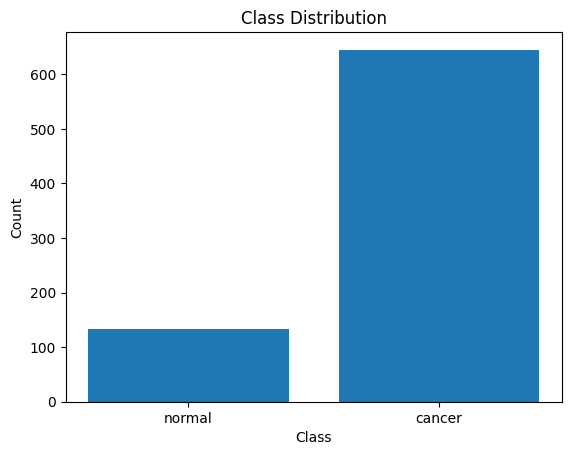

In [44]:
count_and_plot_files(train_path_stage_one, class_names_step_one)

In [45]:
##AUGMENTATION

class SegmentationTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, mask = False):
        # Apply the same transformation to both image and mask
        seed = np.random.randint(0, 2**32)  # Random seed to ensure the same transformations are applied
        torch.manual_seed(seed)
        transformed_image = self.transform(image)

        # To apply the same transformation to the mask, we need to modify the mask tensor as well.
        if mask:
            torch.manual_seed(seed)
            transformed_mask = self.transform(mask)
            
            return transformed_image, transformed_mask
            
        return transformed_image

# Augmentation transformations (for oversampling)
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

seg_transform = SegmentationTransform(augmentation)

In [229]:
def augment_images(path_orig, class_name, desire_num_images, mask = False):
    
    if mask:
        path = os.path.join(path_orig, "images")
        mask_path = os.path.join(path_orig, "masks")
        files = os.listdir(path)
        mask_files = os.listdir(mask_path)
        orig_files = [f for f in files if f.endswith(".png") and  ".DS_Store" not in f and class_name in f]
        # masked_files = [f for f in mask_path if f.endswith(".png") and  ".DS_Store" not in f and class_name in f]
    else:
        path = os.path.join(path_orig, class_name)
        files = os.listdir(path)
        orig_files = [file for file in files if '_mask' not in os.path.basename(file) and '.DS_Store' not in files]   
    aug_each = (desire_num_images - len(orig_files))//len(orig_files) + 1

    for file in tqdm(orig_files, desc="Processing files", unit="file"):
        for num in range(aug_each):
            image_path = os.path.join(path, file)
            image = Image.open(image_path)
            

            if mask:
                
                file_mask = file.split(".")[0] + "_mask.png"
                mask_path_open = os.path.join(mask_path, file_mask)
                mask = Image.open(mask_path_open)
                # Apply augmentation
                augmented_image, augmented_mask = seg_transform(image, mask)
                to_pil = transforms.ToPILImage()
                augmented_img_pil = to_pil(augmented_image)
                augmented_mask_pil = to_pil(augmented_mask)

                augmented_mask_numpy = augmented_mask.numpy().transpose(1, 2, 0)

                augmented_image_filename = file.split(".")[0] + "_aug_" + str(num) + ".png"
                augmented_mask_filename = file.split(".")[0] + "_aug_" + str(num) + "_mask.png"
        
                augmented_img_pil.save(os.path.join(path, augmented_image_filename))
                augmented_mask_pil.save(os.path.join(mask_path, augmented_mask_filename))

            else:
                
                augmented_image = seg_transform(image)
                to_pil = transforms.ToPILImage()
                augmented_img_pil = to_pil(augmented_image)
                augmented_image_filename = file.split(".")[0] + "_aug_" + str(num) + ".png"
                augmented_img_pil.save(os.path.join(path, augmented_image_filename))
            

In [47]:
augment_images(train_path_stage_one, "normal", desire_num_images = 650)

4



rocessing files: 100%|█████████████████████| 133/133 [01:14<00:00,  1.78file/s]

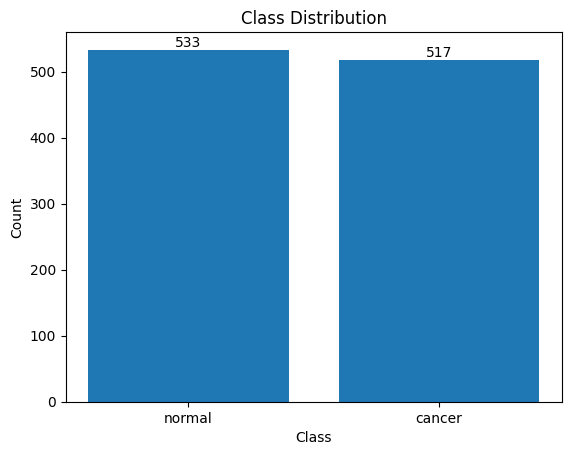

In [176]:
#Counts in train dataset

count_and_plot_files(train_path_stage_one, class_names_step_one , stage = 1)

In [301]:
# Function for splitting dataset

def create_folders(base_dir, new_dir, class_names, subsets=['train', 'val'], mask = False):
    """
    Creates necessary folder structure: Class/{images, masks}
    """
    for subset in subsets:
        for class_name in class_names:
            # Create class folder for subset (train/val)
            
            if mask:
                path = os.path.join(path_orig, "images")
                mask_path = os.path.join(path_orig, "masks")
            else:
                class_folder = os.path.join(new_dir, subset, class_name)
                os.makedirs(class_folder, exist_ok=True)
    print(f"Folders created")

def split_dataset(image_dir, new_dir, class_names, train_ratio=0.8, mask = False):
    """
    Split the dataset into train and val sets for each class.
    """

    for class_name in class_names:
        # Get list of all image and mask filenames
        
        if mask:
            file_path = os.path.join(image_dir, 'images')
            mask_path = os.path.join(image_dir, "masks")
            files = os.listdir(file_path)
            orig_files = [f for f in files if ".DS_Store" not in f and class_name in f]

        else:
            image_files = [f for f in os.listdir(os.path.join(image_dir, class_name)) if f.endswith('.png') and '_mask' not in f]
        # Split into training and validation sets
        train_count = int(len(orig_files) * train_ratio)
        train_images = orig_files[:train_count]
        val_images = orig_files[train_count:]

        # Move files to train and val folders
        for num, image_file in enumerate(val_images):
            if mask:
                mask_file = image_file.split(".")[0] + "_mask.png"
                mask_path_file = os.path.join(mask_path, mask_file)
                image_path = os.path.join(file_path, image_file)
                shutil.move(image_path, os.path.join(new_dir, 'images', image_file))
                shutil.move(mask_path_file, os.path.join(new_dir, 'masks', mask_file))
            else:
                image_path = os.path.join(image_dir, class_name, image_file)
                shutil.move(image_path, os.path.join(new_dir, class_name, image_file))
                
                
    print("Splitting finished")


In [57]:
create_folders(train_path_stage_one, val_path_stage_one, class_names_step_one, subsets=['train', 'val'])

Folders created


In [87]:

# Split dataset into train/val and move images/masks
split_dataset(train_path_stage_one, val_path_stage_one, class_names_step_one, train_ratio=0.8)

Splitting finished


In [89]:
def train_val_datasets(train_path, test_path):
    """
    Creates datasets for training and validation.
    
    Parameters:
    train_path: directory of training folder
    val_path: directory of validation folder
    
    Returns:
    (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_path,
        batch_size=10,
        image_size=target_size,
        shuffle=True,
        seed=seed
    )
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=test_path,
        batch_size=10,
        image_size=target_size,
        shuffle=True,
        seed=seed
    )

    return training_dataset, validation_dataset

In [99]:
def create_pre_trained_model():
    """
    Creates the pretrained EfficientNetB0 model

    Returns:
    tf.keras.Model: pre-trained model
    
    """
    
    pre_trained_model = tf.keras.applications.EfficientNetB0(
        include_top=False,  # Remove the fully connected layer
        input_shape=target_size + (3,),
        weights='imagenet'  # Use pre-trained weights
    )
    pre_trained_model.trainable = False  # Freeze the base model

    return pre_trained_model

In [100]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    """
    Class of callback that contains cases for stopping model training

    patience: number of epoch to wait until improvement in test accuracy
    """
    def __init__(self, patience=5):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.best_accuracy = 0.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        
        if current_accuracy is None:
            return
        
        if current_accuracy - self.best_accuracy >= 0.03: # differense in current test accuracy and best grather or equals to 3% 
            self.best_accuracy = current_accuracy
            self.wait = 0
            print(f"New best accuracy: {self.best_accuracy:.4f}")
        else:
            self.wait += 1
            print(f"No improvement in epoch {epoch + 1}. Waiting {self.wait}/{self.patience}...")

        if self.wait >= self.patience:
            print("Early stopping triggered!")
            self.model.stop_training = True

        if logs['accuracy'] >= 0.99 and logs['val_accuracy'] >= 0.99: # earlystopping
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [101]:
checkpoint = ModelCheckpoint(
    'best_model_EfficientNetB0_base_0.keras',               # File name to save the model
    monitor='val_accuracy',         # Metric to monitor
    save_best_only=True,           # Save only the best model
    mode='max',                    # Mode (max for accuracy)
    verbose=1                      # Verbosity
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',       # Metric to monitor
    factor=0.2,               # Factor by which the learning rate will be reduced
    patience=2,               # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,              # Minimum learning rate
    verbose=1
)

In [103]:
seed = 42

# Load datasets
training_dataset, validation_dataset = train_val_datasets(train_path_stage_one, val_path_stage_one)

# Create base model
base_model = create_pre_trained_model()

Found 1048 files belonging to 2 classes.


2025-01-19 21:26:27.436953: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-19 21:26:27.438257: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-19 21:26:27.438562: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-19 21:26:27.439030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-19 21:26:27.440030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 262 files belonging to 2 classes.


In [104]:
def run_training(model, training_dataset, validation_dataset, danse_neurons, dropout, learning_rate, epochs, patience, filename, verbose):


        # Create the ModelCheckpoint callback with the dynamic filename
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filename,  # Dynamic filename with timestamp and validation accuracy placeholder
        monitor='val_accuracy',  # Metric to monitor
        save_best_only=True,     # Save only the best model
        mode='max',              # Mode (max for accuracy)
        verbose=verbose                # Verbosity
    )

        # EarlyStopping callback
    early_stopping = EarlyStoppingCallback(patience=patience)

        # ReduceLROnPlateau callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=verbose
    )
    
    # Train the model
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = [EarlyStoppingCallback(patience=patience),checkpoint,reduce_lr],
    )
    return model, history

In [105]:
model = models.Sequential([
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')  # For binary classification
    ])
    
    # Compile the model with sparse_categorical_crossentropy for integer-encoded labels
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [149]:
model_trained, history = run_training(model,training_dataset, validation_dataset, danse_neurons = 1024,dropout = 0.1
                                      ,learning_rate = 0.001,epochs = 5, patience = 5, filename = 'model_to_allocate_cancer.keras',verbose = 1)

Epoch 1/5
New best accuracy: 0.9313

Epoch 1: val_accuracy improved from -inf to 0.93130, saving model to model_to_allocate_cancer.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 231ms/step - accuracy: 0.8862 - loss: 0.2413 - val_accuracy: 0.9313 - val_loss: 0.1460 - learning_rate: 0.0010
Epoch 2/5
No improvement in epoch 2. Waiting 1/5...

Epoch 2: val_accuracy improved from 0.93130 to 0.95802, saving model to model_to_allocate_cancer.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.8890 - loss: 0.2589 - val_accuracy: 0.9580 - val_loss: 0.1456 - learning_rate: 0.0010
Epoch 3/5
No improvement in epoch 3. Waiting 2/5...

Epoch 3: val_accuracy did not improve from 0.95802
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.8890 - loss: 0.2689 - val_accuracy: 0.9160 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 4/5
No improvement in epoch 4. Waiting 3/5...

Epoch 4: val_accuracy did not improve from 0.95802

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000

In [152]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = models.Sequential([
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')  # For binary classification
    ])
    
    # Compile the model with sparse_categorical_crossentropy for integer-encoded labels
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [153]:
model_trained, history = run_training(model,training_dataset, validation_dataset, danse_neurons = 1024,dropout = 0.1
                                      ,learning_rate = 0.001,epochs = 5, patience = 5, filename = 'model_to_allocate_cancer.keras',verbose = 1)

Epoch 1/5
New best accuracy: 0.9580

Epoch 1: val_accuracy improved from -inf to 0.95802, saving model to model_to_allocate_cancer.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 91s 601ms/step - accuracy: 0.7396 - loss: 0.6220 - val_accuracy: 0.9580 - val_loss: 0.1285 - learning_rate: 0.0010
Epoch 2/5
No improvement in epoch 2. Waiting 1/5...

Epoch 2: val_accuracy did not improve from 0.95802
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 505ms/step - accuracy: 0.8811 - loss: 0.2933 - val_accuracy: 0.9580 - val_loss: 0.1321 - learning_rate: 0.0010
Epoch 3/5
No improvement in epoch 3. Waiting 2/5...

Epoch 3: val_accuracy did not improve from 0.95802

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 536ms/step - accuracy: 0.9115 - loss: 0.2139 - val_accuracy: 0.9427 - val_loss: 0.1240 - learning_rate: 0.0010
Epoch 4/5
No improvement in epoch 4. Waiting 3/5...

Epoch 4: val_accuracy improved from 0.95802 to 0.97328, saving model to model_to_allocate_ca

In [447]:
all_labels = []
pred = []
for images, labels in validation_dataset:
    # Collect the labels from each batch
    all_labels.append(labels.numpy())
    predictions = model_trained.predict(images, verbose=0)
    binary_predictions = (predictions > 0.5).astype(int)
    pred.append(binary_predictions)

true_lables = np.concatenate(all_labels)   
result = np.concatenate(pred, axis=0)

# If you want the result as a 1D array (flattened version), you can use .flatten() or .ravel()
pred_flat = result.flatten()


2025-01-22 22:57:37.525512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [145]:
def plot_confusion_matrix(Y_true, Y_pred, class_names):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues'
                , xticklabels=class_names, yticklabels=class_names
               )
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

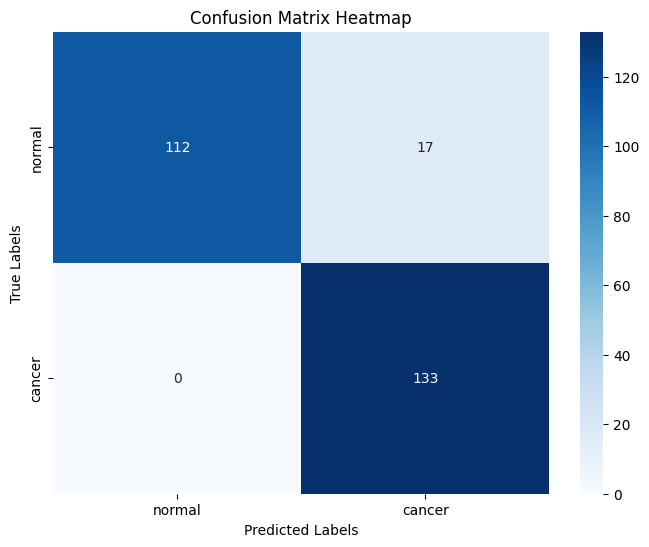

In [448]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plot_confusion_matrix(true_lables, pred_flat, class_names_step_one)

In [156]:
class_names_step_two = ["benign", "malignant"]

train_path_stage_two = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/Second_step/train"
val_path_stage_two = "/Users/sergeiakhmadulin/Documents/Braest Censer/Two steps/Second_step/val"

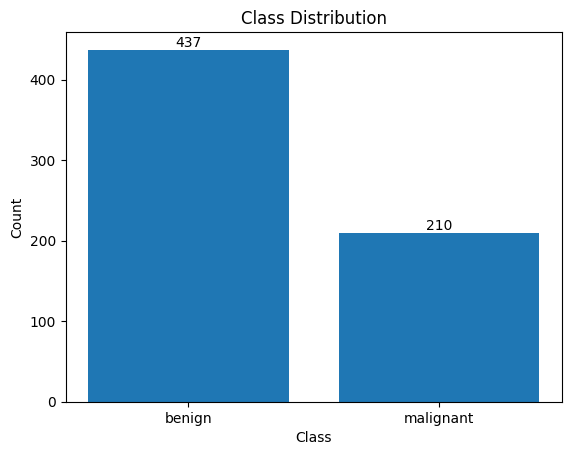

In [175]:
count_and_plot_files(train_path_stage_two, class_names_step_two, stage = 2)

In [183]:
def combine_masks(path, img, orig_name, remove_flag = False, Rectangular = False):
            path_orig_name = os.path.join(path, orig_name)
            first_img = cv2.imread(path_orig_name , cv2.IMREAD_GRAYSCALE)
            
            mask = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
  
            # Apply binary thresholding (convert to a binary mask)
            _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

            new_img = np.zeros_like(first_img)
            # Find contours in the binary mask     
            if Rectangular:
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for contour in contours:
                    
                    x, y, w, h = cv2.boundingRect(contour)
                    if orig_name == img:
                        new_img = cv2.rectangle(new_img, (x, y), (x + w, y + h), (255), -1)  # Green color with thickness 2
                        cv2.imwrite(path_orig_name, new_img)
                    else:
                        first_img = cv2.rectangle(first_img, (x, y), (x + w, y + h), (255), -1)
                        cv2.imwrite(path_orig_name, first_img)
                
            else:
                if orig_name == img:
                    combined_mask = cv2.bitwise_or(new_img,mask)
                    cv2.imwrite(path_orig_name, combined_mask)
                else:
                    combined_mask = cv2.bitwise_or(first_img,mask)
                    cv2.imwrite(path_orig_name, combined_mask)

            if remove_flag:
                os.remove(os.path.join(path, img))

In [186]:
def craete_single_mask_for_file(path, classes, Rectangular,remove_flag = False):
    for class_name in classes:
        full_path = os.path.join(path, "masks")
        files = os.listdir(full_path)
        all_masks = [f for f in files if f.endswith(".png") and "_mask" in f and ".DS_Store" not in f and class_name in f]
        # Filter image files (assuming they are PNGs or another format, adjust as necessary)
        image_files = [f for f in files if f.endswith(".png") and "_mask" in f and ".DS_Store" not in f and "_mask_" not in f and class_name in f]

        # Loop over each image file

        for image_filename in image_files:
    
            mask_files = [f for f in all_masks if image_filename.split(".")[0] in f and "_mask_" in f]
            
            if len(mask_files) > 0:
    
                combine_masks(full_path, image_filename, image_filename, Rectangular = Rectangular)
                for msk_file in mask_files:
                    
                    combine_masks(full_path, msk_file, image_filename, remove_flag = remove_flag, Rectangular = Rectangular)
    
            else:
                combine_masks(full_path, image_filename, image_filename, Rectangular = Rectangular)
    print("Masks are ready")

In [188]:
craete_single_mask_for_file(train_path_stage_two, class_names_step_two, Rectangular = False, remove_flag = True)

Masks are ready


In [234]:
augment_images(train_path_stage_two, "malignant", desire_num_images = 220, mask = True)


rocessing files: 100%|█████████████████████| 210/210 [00:27<00:00,  7.75file/s]

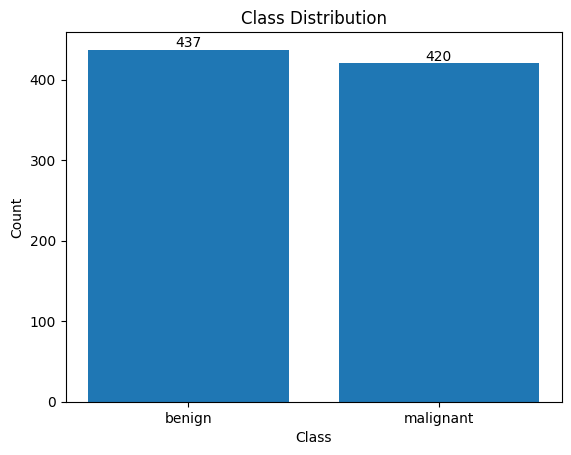

In [235]:
count_and_plot_files(train_path_stage_two, class_names_step_two, stage = 2)

In [242]:
create_folders(train_path_stage_two, val_path_stage_two, class_names_step_two, subsets=['train', 'val'], mask = True)

Folders created


In [302]:
split_dataset(train_path_stage_two, val_path_stage_two, class_names_step_two, train_ratio=0.9, mask = True)

Splitting finished


In [305]:
def get_box_mask(path_masks, files, target_size):
    list_box = []
    
    for mask_file in files:
        # Read the mask as grayscale
        mask = cv2.imread(os.path.join(path_masks, mask_file), cv2.IMREAD_GRAYSCALE)
        
        # Resize the mask to the target size
        img_resized = cv2.resize(mask, target_size)
        
        # Apply thresholding to get a binary mask
        _, binary_mask = cv2.threshold(img_resized, 1, 255, cv2.THRESH_BINARY)
        
        # Apply morphological closing to remove small gaps
        kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size as necessary
        closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # Find contours in the closed binary mask
        contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
    
            # Only add bounding boxes with positive width and height
            if w > 0 and h > 0:
                list_box.append([x, y, x + w, y + h])
    
    return list_box

In [307]:
class UltrasoundDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations  # List of annotations for each image
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx, print_number = False):
        # Load the image
        img_name = os.path.join(self.image_dir, self.annotations[idx]['image_id'])
        image = Image.open(img_name).convert("RGB")
        if print_number:
            print(img_name, torch.tensor([idx]))
        # Get the bounding boxes and labels
        boxes = self.annotations[idx]['boxes']  # This should be a list of bounding boxes
        labels = self.annotations[idx]['labels']
        
        # Convert boxes from list to tensor (Ensure it's a tensor)
        boxes = torch.tensor(boxes, dtype=torch.float32)  # Convert boxes to tensor
        
        # Prepare the target dictionary
        target = {
            'boxes': boxes,  # Convert list to tensor
            'labels': torch.tensor(labels, dtype=torch.int64),  # Convert labels to tensor
            'image_id': torch.tensor([idx]),
            'area': torch.tensor([box[2] * box[3] for box in boxes]),  # box width * height
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)
        }

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, target

In [313]:

transform = T.Compose([
    T.ToTensor(),  # Convert image to tensor
    T.Resize(target_size),  # Resize to a fixed size (you can adjust this)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (same as for COCO dataset)
])

In [309]:
def new_annotation(full_path_img, full_path_masks, target_size, class_names):
    annotations_list = []
    all_files = os.listdir(full_path_img)
    all_masks = os.listdir(full_path_masks)
    for class_name in class_names:
        files_img = [f for f in all_files if f.endswith(".png") and "_mask" not in f and class_name in f and ".DS_Store" not in f]
        
        all_masks_files = [f for f in all_masks if f.endswith(".png") and "_mask" in f and class_name in f and ".DS_Store" not in f]

        
        for file in files_img:
            mask_file = [f for f in all_masks_files if file.split(".")[0] in f and "_mask" in f]


            box = get_box_mask(full_path_masks, mask_file, target_size)
            new_annotation = {
                'image_id': file,
                'boxes': [],  # List of bounding boxes
                'labels': [class_names.index(class_name) + 1] * len(box),  # Class labels (1 = benign, 0 = normal)
                }
            new_annotation["boxes"] = box
            annotations_list.append(new_annotation)
        print(f"Add {len(files_img)} examples of class {class_name}")
    return annotations_list

In [416]:
batch_size = 4

# annotations_tr = new_annotation(os.path.join(train_path_stage_two, "images")
#                                 , os.path.join(train_path_stage_two, "masks"), target_size, class_names_step_two)

# # Create Dataset
# dataset_tr = UltrasoundDataset(image_dir=os.path.join(train_path_stage_two, "images"), annotations=annotations_tr, transform=transform)

# # Create DataLoader
# dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, collate_fn=lambda x: tuple(zip(*x)))


annotations_val = new_annotation(os.path.join(val_path_stage_two, "images")
                                , os.path.join(val_path_stage_two, "masks"), target_size, class_names_step_two)

# Create Dataset
dataset_val = UltrasoundDataset(image_dir=os.path.join(val_path_stage_two, "images"), annotations=annotations_val, transform=transform)

# Create DataLoader
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=lambda x: tuple(zip(*x)))

Add 43 examples of class benign
Add 42 examples of class malignant


In [415]:
image_dir = "/Users/sergeiakhmadulin/Documents/Braest Censer/Try/Train/images"

masks_dir = "/Users/sergeiakhmadulin/Documents/Braest Censer/Try/Train/masks"

annotations_tr = new_annotation(os.path.join(image_dir)
                                , os.path.join(masks_dir), target_size, class_names_step_two)

# Create Dataset
dataset_tr = UltrasoundDataset(image_dir=os.path.join(image_dir), annotations=annotations_tr, transform=transform)

# Create DataLoader
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))




annotations_val = new_annotation(os.path.join("/Users/sergeiakhmadulin/Documents/Braest Censer/Try/Val", "images")
                                , os.path.join("/Users/sergeiakhmadulin/Documents/Braest Censer/Try/Val", "masks"), target_size, class_names_step_two)

# Create Dataset
dataset_val = UltrasoundDataset(image_dir=os.path.join("/Users/sergeiakhmadulin/Documents/Braest Censer/Try/Val", "images"), annotations=annotations_val, transform=transform)

# Create DataLoader
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=lambda x: tuple(zip(*x)))

Add 90 examples of class benign
Add 90 examples of class malignant
Add 10 examples of class benign
Add 12 examples of class malignant


In [342]:
import torchvision.models.detection as detection

# Load a pre-trained Faster R-CNN model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to fit your dataset (3 classes + background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=3)

In [340]:
# Apply NMS to remove redundant boxes
def apply_nms(predictions, iou_threshold=0.5, score_threshold=0.3):
    new_predictions = []
    
    for prediction in predictions:
        boxes_all = prediction['boxes']
        scores_all = prediction['scores']
        labels_all = prediction['labels']
        
        # Filter out low-score predictions
        keep = scores_all >= score_threshold
        boxes = boxes_all[keep]
        scores = scores_all[keep]
        labels = labels_all[keep]

        # Apply NMS (Non-Maximum Suppression)
        keep_idx = nms(boxes, scores, iou_threshold)
        if len(keep_idx) > 0 and (scores >= 0.89).sum() > 1:
            keep_last = scores >= 0.89
            final_box = boxes[keep_last]
            final_score = scores[keep_last]
            final_label = labels[keep_last] 
        elif len(keep_idx) > 0:         
            best_idx = keep_idx[0]
            final_box = boxes[best_idx]
            final_score = scores[best_idx]
            final_label = labels[best_idx]
        else:
            try:
                final_box = boxes_all[0]
                final_score = scores_all[0]
                final_label = labels_all[0]
            except Exception as e:
                print(prediction)
                print(keep_idx)
                raise e
        
        # Add the results to the new predictions
        new_predictions.append({
            'boxes': final_box,
            'scores': final_score,
            'labels': final_label
        })
    
    return new_predictions

In [393]:
def calculate_accuracy(predictions, targets, iou_threshold=0.5, score_threshold=0.3):
    correct = 0
    total = 0
    
    filtered_predictions = apply_nms(predictions, iou_threshold=iou_threshold, score_threshold=score_threshold)
    y_true = []
    y_pred = []
    # print(filtered_predictions)
    for num, target in enumerate(targets):
            pred_labels = filtered_predictions[num]['labels']
            pred_scores = filtered_predictions[num]['scores']
            gt_labels = target['labels']
            
            mean_pred_lbl = round(pred_labels.float().mean().item())
            if pred_labels.sum() >= 2 or len(gt_labels) > 1:
                y_true.append(int(round(gt_labels.float().mean().item())))
                y_pred.append(int(round(pred_labels.float().mean().item())))
                if round(pred_labels.float().mean().item()) in gt_labels:
                    correct += 1

            else:
                y_true.append(int(gt_labels))
                try:
                    y_pred.append(int(pred_labels))
                except Exception as e:
                    print("filtered_pred: ",filtered_predictions)
                    print("pred_lables: ",pred_labels)
                    print("pred_sum: ",pred_labels.sum(), "len_gt_lables: ", len(gt_labels))
                    raise e
                if pred_labels in gt_labels:
                    correct += 1
                    
            total += 1

            # print(f"num: {num}, pred: {pred_labels}, true: {gt_labels}, correct: {correct}, total: {total}")
        
        # print(f"pred: {pred_labels}, griund_true:{gt_labels}, mean:{mean_pred_lbl}")
    accuracy = correct / total if total > 0 else 0
    return accuracy, y_true, y_pred

In [345]:
def test_data_evaluetion(model, dataloader,iou_threshold, score_threshold):

    running_accuracy = 0.0
    # Example evaluation loop (you can adjust for your test dataset)
    N = len(dataloader)
    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        with tqdm(enumerate(dataloader), total=N) as pbar:
            
            for idx, (images, targets) in pbar:
                if idx >= N:
                    break  # Stop after processing N batches
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                prediction = model(images)
                try:
                    accuracy, y_true, y_pred = calculate_accuracy(prediction, targets, iou_threshold=iou_threshold, score_threshold=score_threshold)
                except Exception as e:
                    print("ind",idx)
                    print("targets",targets)
                    print("predictions:", prediction)
                    raise e
                running_accuracy += accuracy
                y_true_list += y_true
                y_pred_list += y_pred
    avg_accuracy = running_accuracy / len(dataloader)
    return avg_accuracy, y_true_list, y_pred_list

In [417]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model to train mode
model.train()

# Use an optimizer (Adam works well for most tasks)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optionally, use a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
best_accuracy = 0
# Define the training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    running_accuracy = 0.0  # Variable to track accuracy
    with tqdm(enumerate(dataloader_tr), total=len(dataloader_tr), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
    
        for idx, (images, targets) in pbar:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            # Zero the gradients
            optimizer.zero_grad()
    
            # Forward pass
            try:
                loss_dict = model(images, targets)
            except Exception as e:
                print(f"Error in batch {idx} of epoch {epoch+1}")
                # Iterate over each image in the batch and print the details
                for i in range(len(targets)):  # There are 4 images in the batch
                    print(f"Image ID {i+1}: {targets[i]['image_id']}")
                    print(f"Bounding boxes: {targets[i]['boxes']}")
                    print(f"Labels: {targets[i]['labels']}")
                raise e  # Re-raise the exception to stop the training
                
            losses = sum(loss for loss in loss_dict.values())
            
            # Backward pass
            losses.backward()
            optimizer.step()
                        
            running_loss += losses.item()
            # model.eval()  # Set model to evaluation mode

    model.eval()
    avg_accuracy, y_true, y_pred = test_data_evaluetion(model, dataloader_val,iou_threshold=0.5, score_threshold=0.3)  
    if avg_accuracy > best_accuracy:
        torch.save(model.state_dict(), '/Users/sergeiakhmadulin/My Drive/Breast Cancer/cancer_classifier.pth')
        best_accuracy = avg_accuracy
    model.train()
    
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader_tr):.4f}, Accuracy: {avg_accuracy * 100:.2f}%")




00%|███████████████████████████████████████████| 22/22 [01:36<00:00,  4.41s/it]

Epoch 1/5, Loss: 0.1626, Accuracy: 77.27%




00%|███████████████████████████████████████████| 22/22 [01:35<00:00,  4.35s/it]

Epoch 2/5, Loss: 0.1367, Accuracy: 85.23%



poch 3/5:   2%|▋                                | 1/45 [00:13<09:37, 13.13s/it]

KeyboardInterrupt: 

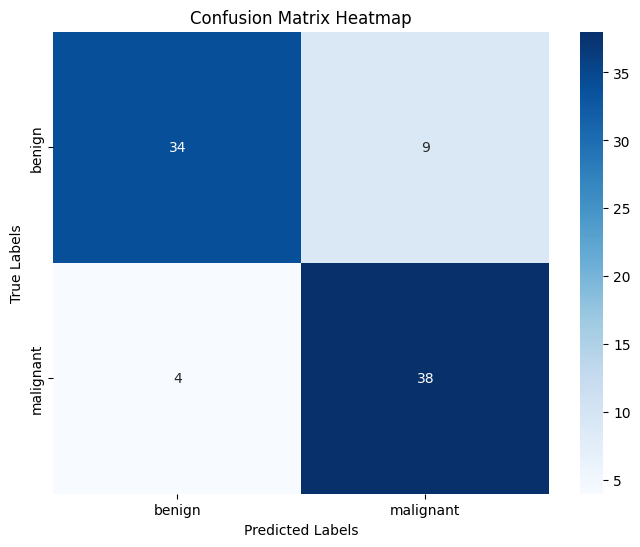

In [418]:
plot_confusion_matrix(y_true, y_pred, class_names_step_two)

In [548]:
def show_model_result_examples(path, class_name, name_table = "Original"):
    """
    Function that shows 4 images for given path and class name

    Parameters:
    path: location for folders of classes with images
    class_name: variable of given names of classes
    augmented: flag of augmentation
    name_table: table name that indicates wather images are original or augmentated

    Outputs:
    Nothing, just shows images
    """
    full_path = os.path.join(path ,class_name)
    files = os.listdir(full_path)
    files = [f for f in files if f.endswith(".png") and "_mask" not in f and class_name in f and ".DS_Store" not in f]
    files_new_list = random.sample(files, 4)
    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    fig.suptitle(f'Examples of class: {class_name}', fontsize=16)

    for i, image in enumerate(files_new_list):
        # img = load_img(os.path.join(full_path,image))
        axes[i].imshow(return_image_result(os.path.join(full_path,image),target_size))
        axes[i].set_title(f'Example: {image}')
    
    plt.show()

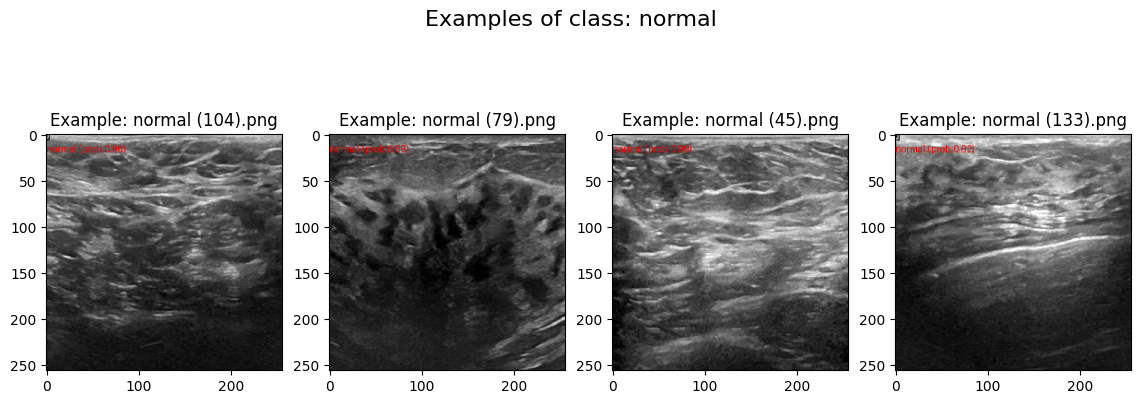

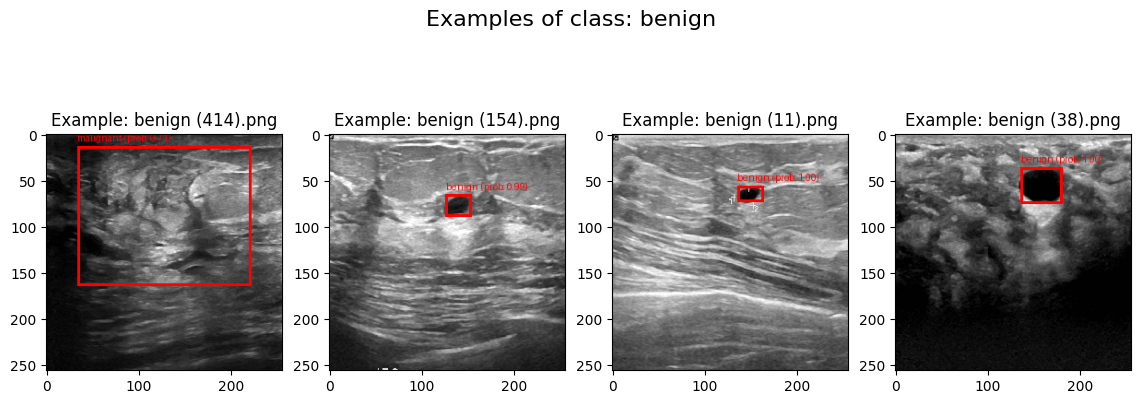

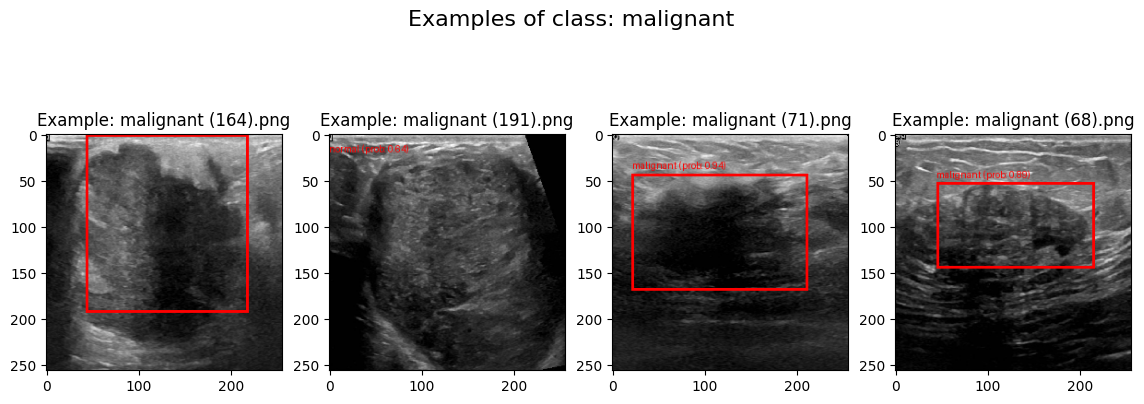

In [545]:
def return_image_result(path, target_size):
    img = load_img(path, target_size=target_size)
    img_array = np.array(img)
    
    img_array = np.expand_dims(img_array, axis=0)
    pred_prob = model_test.predict(img_array, verbose=0)[0][0]
    cancer = pred_prob < 0.5
    # pred_prob = 1 - pred_prob
    if cancer:
        pred_prob = 1 - pred_prob
        image_tensor = transform(img).unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            prediction = model(image_tensor)
        # Example: Apply NMS to the prediction
        filtered_predictions = apply_nms(prediction, iou_threshold=0.5, score_threshold=0.3) 
        class_names = class_names_step_two
    
        boxes = filtered_predictions[0]['boxes']
        labels = filtered_predictions[0]['labels']
        scores = filtered_predictions[0]['scores']
        # print(scores)
        threshold = 0.4
        filtered_boxes = boxes[scores > threshold]
        filtered_labels = labels[scores > threshold]
        filtered_scores = scores[scores > threshold]
    
        draw = ImageDraw.Draw(img)
        for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
            xmin, ymin, xmax, ymax = box
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
            draw.text((xmin, ymin - 15), f'{class_names[label.item()-1]} (prob: {score:.2f})', fill="red")
    
    else:
        draw = ImageDraw.Draw(img)
        # Draw the text on the image
        draw.text((0,0+10), f'{class_names_step_one[cancer]} (prob: {pred_prob:.2f})', fill="red")
    return img